In [66]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
#from sklearn.linear_model import LinearRegression
#import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
from scipy.stats import norm
from sklearn.metrics import r2_score

In [67]:
# Laste poll-of-polls data
df = pd.read_csv("../data/pollofpolls.csv", sep=";")

In [68]:
#df = df[2:]

In [69]:
df

,Mnd,Ap,Hoyre,Frp,SV,Sp,KrF,Venstre,MDG,Rodt,Andre
0,Februar-25,24.8,18.4,24.6,7.4,6.6,3.0,4.2,2.4,5.4,3.2
1,Januar-25,19.1,22.2,24.1,8.0,5.9,3.4,4.5,3.3,5.6,3.9
2,Desember-24,17.2,21.2,25.4,9.4,5.3,3.9,5.3,3.1,5.8,3.5
3,November-24,18.7,22.4,22.0,9.0,6.6,3.1,5.1,3.4,5.9,3.8
4,Oktober-24,19.9,23.4,20.3,8.8,5.8,3.3,5.5,3.5,5.9,3.7
...,...,...,...,...,...,...,...,...,...,...,...
201,Mai-08,28.9,17.8,25.9,6.7,5.7,6.2,6.2,0.0,1.4,0.0
202,April-08,29.0,16.9,25.4,6.5,5.5,7.0,6.8,0.0,1.2,0.0
203,Mars-08,28.7,18.1,25.2,7.0,5.6,6.1,6.3,0.0,1.1,0.0
204,Februar-08,29.0,17.3,25.2,6.7,5.9,6.3,6.6,0.0,1.3,0.0


In [70]:
# Ensure the "Mnd" column is treated as a string (optional but recommended)
#df["Mnd"] = df["Mnd"].astype(str)

# tom dict for prediksjoner
predictions = {"Mnd": ["Mars-25","April-25","Mai-25","Juni-25","Juli-25","August-25","September-25"]}

In [71]:
###for å kunne konvertere til dato datatype
month_mapping = {
    "Januar": "January", "Februar": "February", "Mars": "March", "April": "April",
    "Mai": "May", "Juni": "June", "Juli": "July", "August": "August",
    "September": "September", "Oktober": "October", "November": "November", "Desember": "December"
}

# Replace Norwegian months with English
df["Mnd"] = df["Mnd"].replace(month_mapping, regex=True)

In [72]:
# Convert to datetime and set the date to the end of the month
df["Mnd"] = pd.to_datetime(df["Mnd"], format="%B-%y").dt.to_period("M").dt.to_timestamp("M")

# Sort values and set index
df = df.sort_values("Mnd")
df.set_index("Mnd", inplace=True)

In [73]:
df

,Ap,Hoyre,Frp,SV,Sp,KrF,Venstre,MDG,Rodt,Andre
Mnd,,,,,,,,,,
2008-01-31,29.3,17.2,23.9,7.4,6.1,6.4,6.5,0.0,1.3,0.0
2008-02-29,29.0,17.3,25.2,6.7,5.9,6.3,6.6,0.0,1.3,0.0
2008-03-31,28.7,18.1,25.2,7.0,5.6,6.1,6.3,0.0,1.1,0.0
2008-04-30,29.0,16.9,25.4,6.5,5.5,7.0,6.8,0.0,1.2,0.0
2008-05-31,28.9,17.8,25.9,6.7,5.7,6.2,6.2,0.0,1.4,0.0
...,...,...,...,...,...,...,...,...,...,...
2024-10-31,19.9,23.4,20.3,8.8,5.8,3.3,5.5,3.5,5.9,3.7
2024-11-30,18.7,22.4,22.0,9.0,6.6,3.1,5.1,3.4,5.9,3.8
2024-12-31,17.2,21.2,25.4,9.4,5.3,3.9,5.3,3.1,5.8,3.5


In [74]:
# Perform ADF test on each party's time series
for party in ['Ap', 'Hoyre', 'Frp', 'SV', 'Sp', 'KrF', 'Venstre', 'MDG','Rodt', 'Andre']: 
    result = adfuller(df[party])
    print(f"{party} ADF Statistic: {result[0]}, p-value: {result[1]}")
    if result[1] > 0.05:
        print(f"Warning: {party} is not stationary, consider differencing.")

Ap ADF Statistic: -1.7801822589557765, p-value: 0.39034408610867655
Hoyre ADF Statistic: -2.2989231540603043, p-value: 0.17231551097951114
Frp ADF Statistic: -1.582571861819359, p-value: 0.49234205741872633
SV ADF Statistic: -1.160916983088228, p-value: 0.6901783573567423
Sp ADF Statistic: -1.6059394874788055, p-value: 0.48060925134060084
KrF ADF Statistic: -1.8947928921859223, p-value: 0.33451464977124046
Venstre ADF Statistic: -2.8586375025689597, p-value: 0.05037365394503086
MDG ADF Statistic: -1.6159866377465042, p-value: 0.47483396704156744
Rodt ADF Statistic: -0.6134683727205307, p-value: 0.8679095925971021
Andre ADF Statistic: -1.7235826457432835, p-value: 0.4190047711122682


In [75]:
df_diff = df.diff().dropna()  # Difference to make stationary

In [76]:
df_diff

,Ap,Hoyre,Frp,SV,Sp,KrF,Venstre,MDG,Rodt,Andre
Mnd,,,,,,,,,,
2008-02-29,-0.3,0.1,1.3,-0.7,-0.2,-0.1,0.1,0.0,0.0,0.0
2008-03-31,-0.3,0.8,0.0,0.3,-0.3,-0.2,-0.3,0.0,-0.2,0.0
2008-04-30,0.3,-1.2,0.2,-0.5,-0.1,0.9,0.5,0.0,0.1,0.0
2008-05-31,-0.1,0.9,0.5,0.2,0.2,-0.8,-0.6,0.0,0.2,0.0
2008-06-30,-2.9,-0.2,3.0,0.2,-0.4,-0.1,-0.3,0.0,0.4,0.0
...,...,...,...,...,...,...,...,...,...,...
2024-10-31,-0.7,-1.2,1.4,-0.2,-0.2,0.4,0.4,0.2,0.3,-0.2
2024-11-30,-1.2,-1.0,1.7,0.2,0.8,-0.2,-0.4,-0.1,0.0,0.1
2024-12-31,-1.5,-1.2,3.4,0.4,-1.3,0.8,0.2,-0.3,-0.1,-0.3


In [77]:
# ADF test on each column of df_diff
for col in df_diff.columns:
    result = adfuller(df_diff[col])
    print(f'{col}: p-value={result[1]}')

Ap: p-value=2.190660509485432e-19
Hoyre: p-value=1.4521498128779044e-11
Frp: p-value=5.315407770750361e-25
SV: p-value=2.8982918708725965e-22
Sp: p-value=5.076933478958635e-28
KrF: p-value=5.600375947842685e-25
Venstre: p-value=9.836451838517387e-26
MDG: p-value=9.368030291352459e-29
Rodt: p-value=1.5148471030925746e-13
Andre: p-value=1.31063897913123e-29


In [78]:
model = VAR(df_diff)  
model_fitted = model.fit(maxlags=10,method = 'ols', trend='n', verbose=True)

# Display the summary of the fitted model
print(model_fitted.summary())

C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 14, Mar, 2025
Time:                     08:25:56
--------------------------------------------------------------------
No. of Equations:         10.0000    BIC:                    5.64722
Nobs:                     195.000    HQIC:                  -4.34150
Log likelihood:          -681.034    FPE:                4.26356e-05
AIC:                     -11.1374    Det(Omega_mle):     6.79045e-07
--------------------------------------------------------------------
Results for equation Ap
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
L1.Ap              -1.592051         0.537397           -2.963           0.003
L1.Hoyre           -1.490379         0.539932           -2.760           0.006
L1.Frp             -1.694446         0.543085           -3.120         

In [79]:
# Compute R² for each party
r2_scores = {}
for party in df_diff.columns:
    r2_scores[party] = r2_score(df_diff[party].iloc[model_fitted.k_ar:], model_fitted.fittedvalues[party])

# Print R² values
for party, r2 in r2_scores.items():
    print(f"R² for {party}: {r2:.4f}")

R² for Ap: 0.5190
R² for Hoyre: 0.5196
R² for Frp: 0.5014
R² for SV: 0.5773
R² for Sp: 0.4942
R² for KrF: 0.5955
R² for Venstre: 0.5544
R² for MDG: 0.5119
R² for Rodt: 0.5746
R² for Andre: 0.5863


In [80]:
# Compute MAE, MSE, RMSE, and MAPE for each party
mae_scores = {}
mse_scores = {}
rmse_scores = {}

for party in df_diff.columns:
    actual = df_diff[party].iloc[model_fitted.k_ar:]
    predicted = model_fitted.fittedvalues[party]
    
    mae_scores[party] = mean_absolute_error(actual, predicted)
    mse_scores[party] = mean_squared_error(actual, predicted)
    rmse_scores[party] = np.sqrt(mse_scores[party])  # RMSE

# Print MAE, MSE, RMSE, and MAPE values
for party in df_diff.columns:
    print(f"MAE for {party}: {mae_scores[party]:.4f}")
    print(f"MSE for {party}: {mse_scores[party]:.4f}")
    print(f"RMSE for {party}: {rmse_scores[party]:.4f}")


MAE for Ap: 0.7900
MSE for Ap: 1.0458
RMSE for Ap: 1.0227
MAE for Hoyre: 0.6976
MSE for Hoyre: 0.7892
RMSE for Hoyre: 0.8883
MAE for Frp: 0.6201
MSE for Frp: 0.6298
RMSE for Frp: 0.7936
MAE for SV: 0.2384
MSE for SV: 0.0887
RMSE for SV: 0.2979
MAE for Sp: 0.4966
MSE for Sp: 0.4100
RMSE for Sp: 0.6403
MAE for KrF: 0.1908
MSE for KrF: 0.0612
RMSE for KrF: 0.2474
MAE for Venstre: 0.2332
MSE for Venstre: 0.0845
RMSE for Venstre: 0.2907
MAE for MDG: 0.1922
MSE for MDG: 0.0602
RMSE for MDG: 0.2454
MAE for Rodt: 0.2464
MSE for Rodt: 0.0966
RMSE for Rodt: 0.3108
MAE for Andre: 0.2039
MSE for Andre: 0.0667
RMSE for Andre: 0.2583


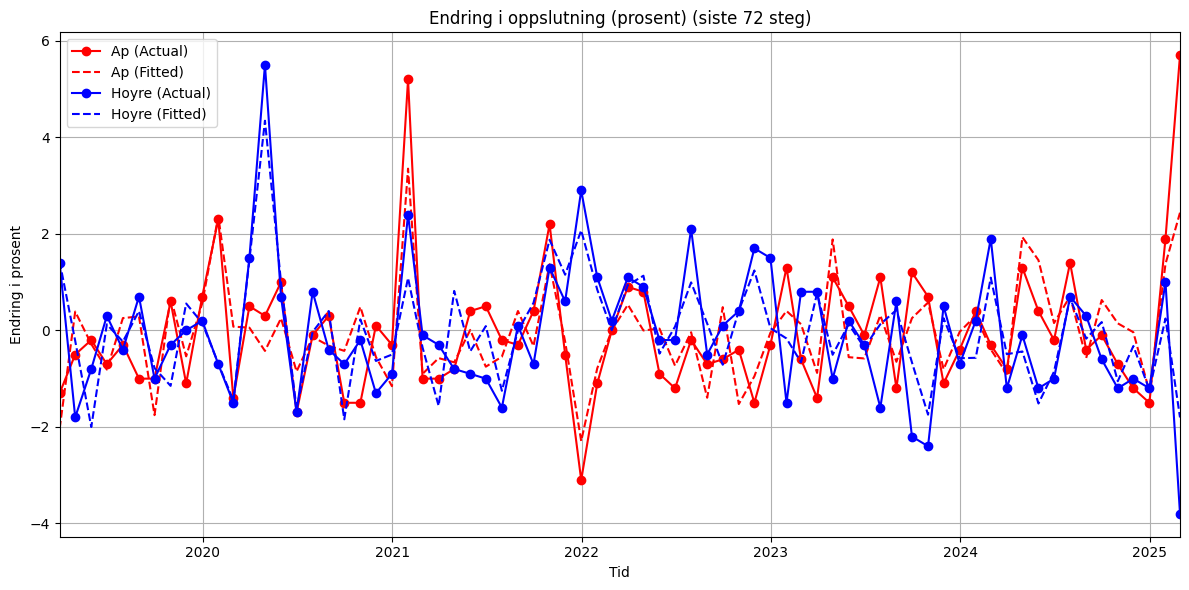

In [81]:
# Define a color map for consistency
colors = {
    'Ap': '#FF0000',        # Red
    'Hoyre': '#0000FF',     # Blue
}

# Number of time steps to plot back in time
steps = 72

# Get fitted values (predicted changes in differenced scale)
fitted_values = model_fitted.fittedvalues[-steps:]

# Create a figure for plotting
plt.figure(figsize=(12, 6))

for party in colors.keys():  # Iterate over defined parties
    color = colors[party]

    # Extract actual data for the last 'steps' data points
    actual_data = df_diff[party].iloc[-steps:]
    
    # Plot actual data (last 'steps' points)
    plt.plot(df_diff.index[-steps:], actual_data, marker="o", color=color, label=f"{party} (Actual)")

    # Plot fitted values (dashed line)
    plt.plot(fitted_values.index, fitted_values[party], linestyle="dashed", color=color, label=f"{party} (Fitted)")

    # Calculate the R-squared value between actual and fitted values
    r2 = r2_score(actual_data, fitted_values[party])

    # Print the R-squared value on the plot
    #plt.text(0.9, 0.1, f"R²: {r2:.4f}", transform=plt.gca().transAxes, fontsize=12, verticalalignment='bottom')

plt.xlim(df.index[-steps], df.index[-1])  # Set x-axis range to last 'steps' records
plt.xlabel("Tid")
plt.ylabel("Endring i prosent")
plt.title("Endring i oppslutning (prosent) (siste 72 steg)")

# Show the legend
plt.legend(loc="upper left")
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


In [82]:
res1=model_fitted.test_normality(0.1)
print(res1)

<statsmodels.tsa.vector_ar.hypothesis_test_results.NormalityTestResults object. H_0: data generated by normally-distributed process: reject at 10% significance level. Test statistic: 91.258, critical value: 28.412>, p-value: 0.000>


In [83]:
# Check if the VAR model is stable (roots inside the unit circle)
print("Is the VAR model stable?", model_fitted.is_stable())

Is the VAR model stable? True


In [84]:
steps = 7  # Number of steps to forecast
alpha = 0.50

forecast, lower, upper = model_fitted.forecast_interval(df_diff.values[-model_fitted.k_ar:], steps=steps, alpha=alpha)

# Convert forecasted values to DataFrames
forecast_dates = pd.date_range(start="2025-03-31", periods=steps, freq='ME')

forecast_diff_df = pd.DataFrame(forecast, index=forecast_dates, columns=df.columns)
forecast_lower_diff_df = pd.DataFrame(lower, index=forecast_dates, columns=df.columns)
forecast_upper_diff_df = pd.DataFrame(upper, index=forecast_dates, columns=df.columns)

# Convert predictions back to original scale
last_actual_value = df.iloc[-1]  # Last known actual data point

forecast_original_scale = forecast_diff_df.cumsum() + last_actual_value
forecast_lower_original_scale = forecast_lower_diff_df.cumsum() + last_actual_value
forecast_upper_original_scale = forecast_upper_diff_df.cumsum() + last_actual_value


In [85]:
forecast_dates

DatetimeIndex(['2025-03-31', '2025-04-30', '2025-05-31', '2025-06-30',
               '2025-07-31', '2025-08-31', '2025-09-30'],
              dtype='datetime64[ns]', freq='ME')

In [86]:
# Get forecast covariance in differenced scale
forecast_cov_diff = model_fitted.forecast_cov(steps=steps)

# Initialize original scale covariance matrix
forecast_cov_original_scale = np.zeros_like(forecast_cov_diff)

# Cumulative sum of covariance matrices to restore original scale
for t in range(steps):
    forecast_cov_original_scale[t] = np.sum(forecast_cov_diff[:t+1], axis=0)

# Convert to DataFrames for readability
forecast_cov_original_df = {t: pd.DataFrame(forecast_cov_original_scale[t], index=df.columns, columns=df.columns)
                            for t in range(steps)}


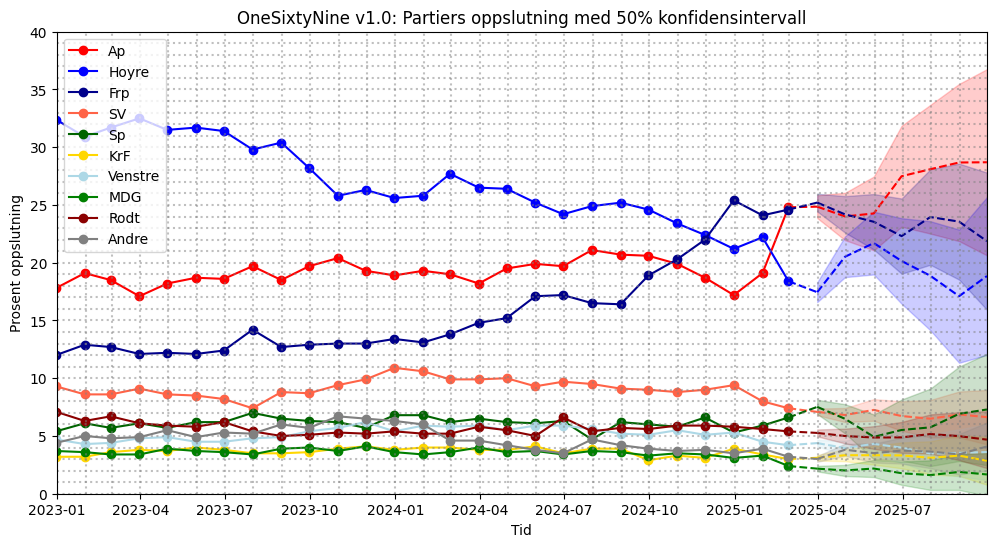

In [87]:
# Define a color map for consistency
colors = {
    'Ap': '#FF0000',        # Red
    'Hoyre': '#0000FF',     # Blue
    'Frp': '#00008B',       # Dark Blue
    'SV': '#FF6347',        # Light Red (Tomato)
    'Sp': '#006400',        # Dark Green
    'KrF': '#FFD700',       # Yellow (Gold)
    'Venstre': '#ADD8E6',   # Light Blue
    'MDG': '#008000',       # Green
    'Rodt': '#8B0000',      # Dark Red
    'Andre': '#808080'      # Gray
}

plt.figure(figsize=(12, 6))

for party in colors.keys():  # Iterate over defined parties
    color = colors[party]  

    # Plot actual data
    plt.plot(df.index, df[party], marker="o", color=color, label=f"{party}")

    # Plot forecast (original scale)
    plt.plot(forecast_original_scale.index, forecast_original_scale[party], linestyle="dashed", color=color)

    last_actual_date = df.index[-1]
    first_forecast_date = forecast_original_scale.index[0]
    last_actual_value = df[party].iloc[-1]
    first_forecast_value = forecast_original_scale[party].iloc[0]

    plt.plot([last_actual_date, first_forecast_date], [last_actual_value, first_forecast_value], color=color, linestyle="dashed")
    
    # Plot confidence interval (original scale)
    plt.fill_between(forecast_original_scale.index, 
                     forecast_lower_original_scale[party], 
                     forecast_upper_original_scale[party], 
                     color=color, alpha=0.2)


dates = pd.date_range(start="2023-01-01", end="2025-09-30", freq="MS")  # "MS" = Month Start
for date in dates:
    plt.axvline(date, color="gray", linestyle="dotted", alpha=0.5)

# Add horizontal grid lines every 5%
for percent in range(0, 45, 1):
    plt.axhline(percent, color="gray", linestyle="dotted", alpha=0.5)

plt.xlim(np.datetime64("2023-01-01"), np.datetime64("2025-09-30"))  # Manually set max date to Sept 2025
plt.ylim(0,40)  # Manually set max date to Sept 2025
plt.xlabel("Tid")
plt.ylabel("Prosent oppslutning")
plt.title("OneSixtyNine v1.0: Partiers oppslutning med 50% konfidensintervall")
plt.legend(loc="upper left")
plt.show()

In [88]:
forecast_original_scale

,Ap,Hoyre,Frp,SV,Sp,KrF,Venstre,MDG,Rodt,Andre
2025-03-31,24.855591,17.447363,25.206267,7.085370,7.518850,3.110415,4.383008,2.171217,5.262956,3.012713
2025-04-30,24.004470,20.517043,24.186049,6.814252,6.484430,3.334868,3.960295,2.013044,4.997798,3.808417
2025-05-31,24.266597,21.700391,23.544688,7.256159,4.922843,3.330570,4.316357,2.181250,4.864731,3.516116
2025-06-30,27.489000,20.151852,22.303631,6.725976,5.519081,3.318372,3.989983,1.775397,4.879423,3.735195
2025-07-31,28.095430,18.872080,23.955420,6.493965,5.747089,3.106760,3.483614,1.612118,5.167638,3.651390
2025-08-31,28.677630,17.101674,23.558824,6.862006,6.917274,3.300551,3.536006,1.890557,4.984995,3.412041
2025-09-30,28.698343,18.846755,21.869915,6.630902,7.293204,2.852084,3.608749,1.667338,4.682685,4.089663


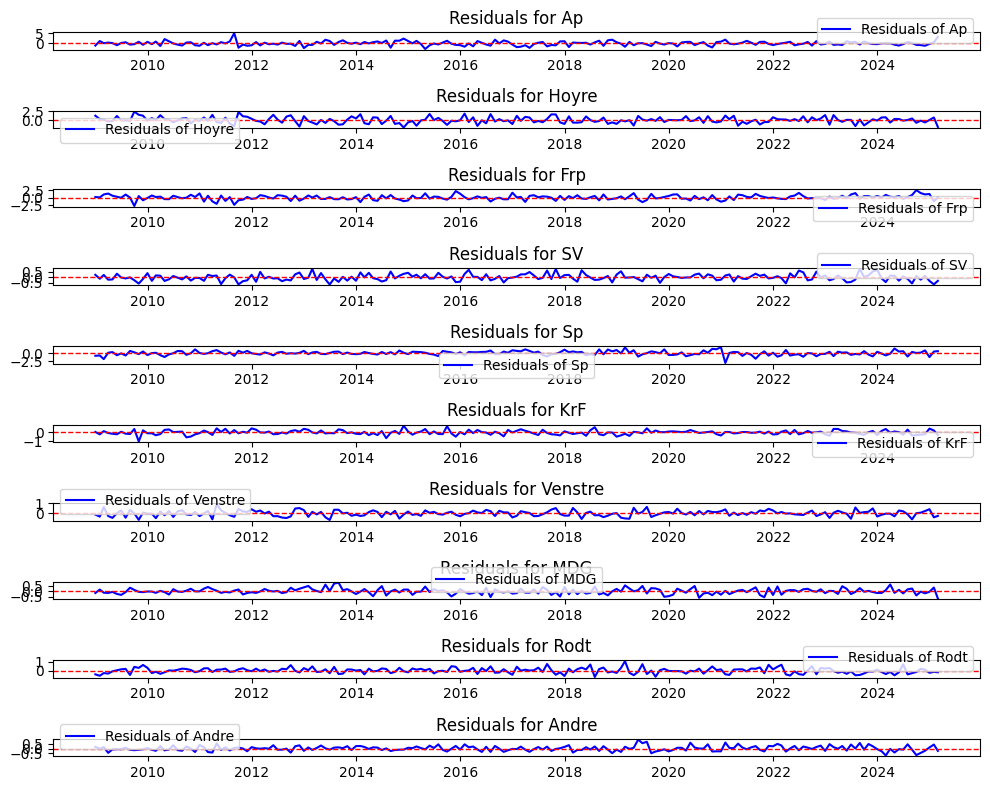

In [89]:

# Get residuals from the fitted model
residuals = model_fitted.resid  # Residuals for all variables

# Plot residuals for each variable
fig, axes = plt.subplots(nrows=residuals.shape[1], ncols=1, figsize=(10, 8))

for i, col in enumerate(residuals.columns):
    axes[i].plot(residuals.index, residuals[col], label=f"Residuals of {col}", color="blue")
    axes[i].axhline(y=0, linestyle="--", color="red", linewidth=1)
    axes[i].set_title(f"Residuals for {col}")
    axes[i].legend()

plt.tight_layout()
plt.show()

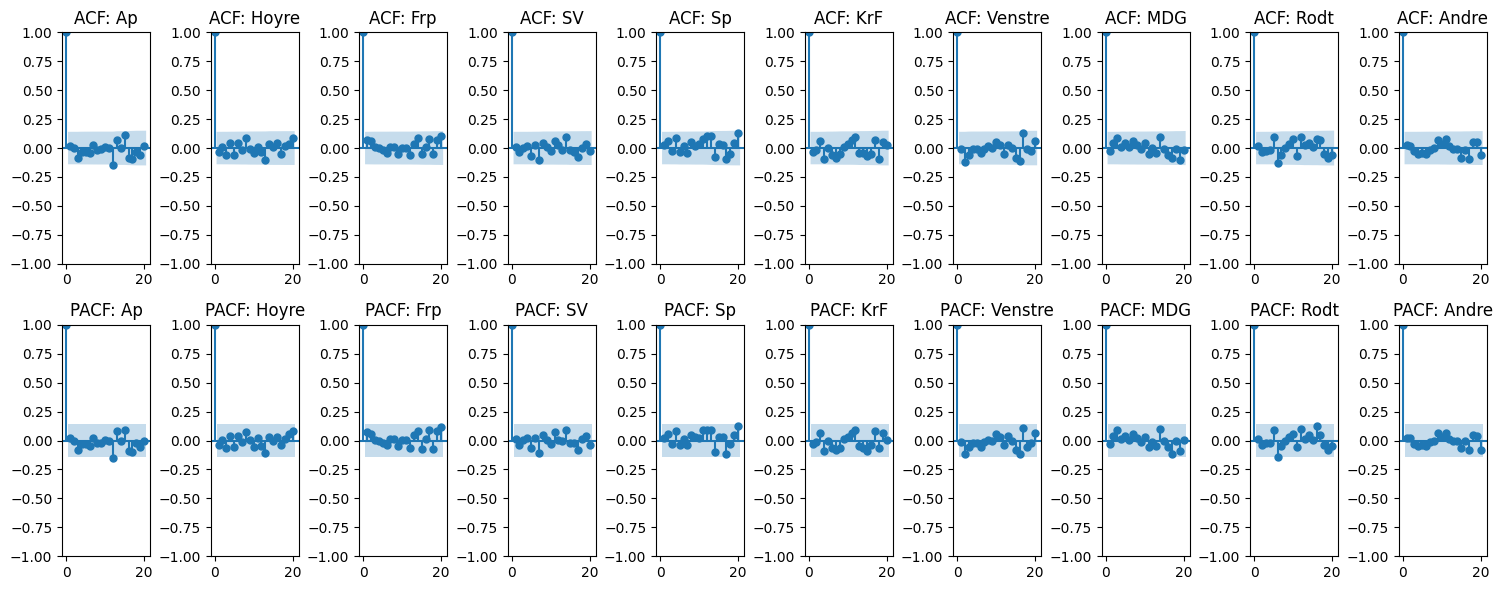

In [90]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF & PACF for residuals of the first variable
fig, axes = plt.subplots(nrows=2, ncols=residuals.shape[1], figsize=(15, 6))

for i, col in enumerate(residuals.columns):
    plot_acf(residuals[col], ax=axes[0, i], lags=20, title=f"ACF: {col}")
    plot_pacf(residuals[col], ax=axes[1, i], lags=20, title=f"PACF: {col}")

plt.tight_layout()
plt.show()

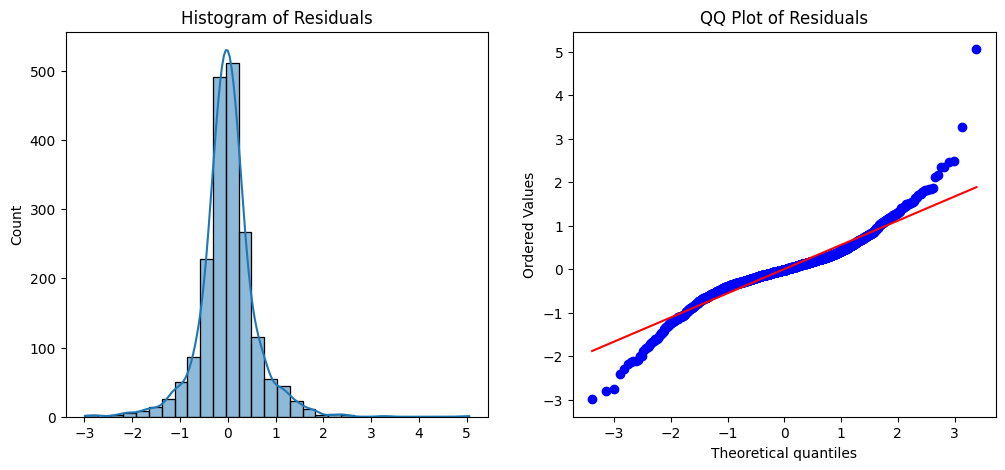

In [91]:
import scipy.stats as stats

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Histogram of residuals
sns.histplot(residuals.values.flatten(), kde=True, ax=axes[0], bins=30)
axes[0].set_title("Histogram of Residuals")

# QQ Plot
stats.probplot(residuals.values.flatten(), dist="norm", plot=axes[1])
axes[1].set_title("QQ Plot of Residuals")

plt.show()


In [92]:
forecast_lower_original_scale


,Ap,Hoyre,Frp,SV,Sp,KrF,Venstre,MDG,Rodt,Andre
2025-03-31,23.867356,16.588919,24.439403,6.797495,6.900084,2.871315,4.102140,1.934122,4.962630,2.763111
2025-04-30,21.952249,18.753626,22.609297,6.206507,5.218737,2.814138,3.344345,1.530518,4.359896,3.281230
2025-05-31,21.073783,18.982493,21.142286,6.317848,2.982020,2.518709,3.355676,1.442075,3.880483,2.700790
2025-06-30,23.117467,16.448650,19.047597,5.452870,2.880594,2.197990,2.677145,0.768760,3.544795,2.612724
2025-07-31,22.522965,14.149961,19.825327,4.870393,2.391960,1.672840,1.810251,0.329551,3.468853,2.216173
2025-08-31,21.873144,11.334704,18.537743,4.875335,2.833666,1.546284,1.495091,0.326447,2.910559,1.658528
2025-09-30,20.637281,12.017155,15.934883,4.276348,2.469388,0.774245,1.188313,-0.182417,2.221563,2.005351


In [93]:
forecast_upper_original_scale

,Ap,Hoyre,Frp,SV,Sp,KrF,Venstre,MDG,Rodt,Andre
2025-03-31,25.843827,18.305808,25.973130,7.373244,8.137615,3.349515,4.663877,2.408311,5.563282,3.262316
2025-04-30,26.056691,22.280460,25.762801,7.421996,7.750123,3.855598,4.576246,2.495569,5.635699,4.335603
2025-05-31,27.459411,24.418288,25.947090,8.194469,6.863666,4.142431,5.277038,2.920425,5.848978,4.331442
2025-06-30,31.860533,23.855054,25.559664,7.999082,8.157568,4.438753,5.302821,2.782034,6.214052,4.857667
2025-07-31,33.667895,23.594198,28.085514,8.117538,9.102218,4.540679,5.156976,2.894685,6.866424,5.086608
2025-08-31,35.482116,22.868643,28.579906,8.848677,11.000881,5.054818,5.576922,3.454666,7.059430,5.165554
2025-09-30,36.759405,25.676355,27.804946,8.985456,12.117021,4.929924,6.029186,3.517093,7.143808,6.173975


In [94]:
# Example: Your existing dataframes (assuming they have the same index and columns)
date_to_extract = "2025-09-30"

# Extract the row for the given date from each dataframe
estimate_row = forecast_original_scale.loc[date_to_extract]
lower_row = forecast_lower_original_scale.loc[date_to_extract]
upper_row = forecast_upper_original_scale.loc[date_to_extract]

# Combine into a new DataFrame
result_df = pd.DataFrame({
    "Party": estimate_row.index,
    "Estimate": estimate_row.values,
    "Lower": lower_row.values,
    "Upper": upper_row.values
})

# Display the final structured DataFrame
print(result_df)


     Party   Estimate      Lower      Upper
0       Ap  28.698343  20.637281  36.759405
1    Hoyre  18.846755  12.017155  25.676355
2      Frp  21.869915  15.934883  27.804946
3       SV   6.630902   4.276348   8.985456
4       Sp   7.293204   2.469388  12.117021
5      KrF   2.852084   0.774245   4.929924
6  Venstre   3.608749   1.188313   6.029186
7      MDG   1.667338  -0.182417   3.517093
8     Rodt   4.682685   2.221563   7.143808
9    Andre   4.089663   2.005351   6.173975


In [95]:
forecast_original_scale

,Ap,Hoyre,Frp,SV,Sp,KrF,Venstre,MDG,Rodt,Andre
2025-03-31,24.855591,17.447363,25.206267,7.085370,7.518850,3.110415,4.383008,2.171217,5.262956,3.012713
2025-04-30,24.004470,20.517043,24.186049,6.814252,6.484430,3.334868,3.960295,2.013044,4.997798,3.808417
2025-05-31,24.266597,21.700391,23.544688,7.256159,4.922843,3.330570,4.316357,2.181250,4.864731,3.516116
2025-06-30,27.489000,20.151852,22.303631,6.725976,5.519081,3.318372,3.989983,1.775397,4.879423,3.735195
2025-07-31,28.095430,18.872080,23.955420,6.493965,5.747089,3.106760,3.483614,1.612118,5.167638,3.651390
2025-08-31,28.677630,17.101674,23.558824,6.862006,6.917274,3.300551,3.536006,1.890557,4.984995,3.412041
2025-09-30,28.698343,18.846755,21.869915,6.630902,7.293204,2.852084,3.608749,1.667338,4.682685,4.089663


In [96]:
# Multivariate MC!
n_sim = 1000000
# Extract mean estimates (yhat) and covariance matrix
yhat_vector = result_df["Estimate"].values  # Mean estimates for all parties
#yhat_vector = forecast_original_scale["Estimate"].values  # Mean estimates for all parties
cov_matrix = forecast_cov_original_scale[-1]  # Covariance matrix at final step (latest forecast)

# Generate correlated samples
samples = np.random.multivariate_normal(yhat_vector, cov_matrix, size=n_sim)
samples = np.maximum(samples, 1e-6) ##must be above 0
samples = (samples.T / samples.sum(axis=1) * 100).T

# Create a DataFrame with sampled values
sampled_df = pd.DataFrame(samples, columns=result_df["Party"])

# Compute vote totals for each simulation
red_green_votes = sampled_df[["Ap", "SV", "Sp", "Rodt", "MDG"]].sum(axis=1)/sampled_df.sum(axis=1)
blue_votes = sampled_df[["Hoyre", "Frp", "KrF", "Venstre"]].sum(axis=1)/sampled_df.sum(axis=1)

# Probability that red-green block wins
prob_red_green_wins = np.mean(red_green_votes > blue_votes)

print(f"Sannsyn for at Ap+SV+Sp+R+MDG > H+FrP+KrF+V: {prob_red_green_wins:.4f}")


Sannsyn for at Ap+SV+Sp+R+MDG > H+FrP+KrF+V: 0.5826


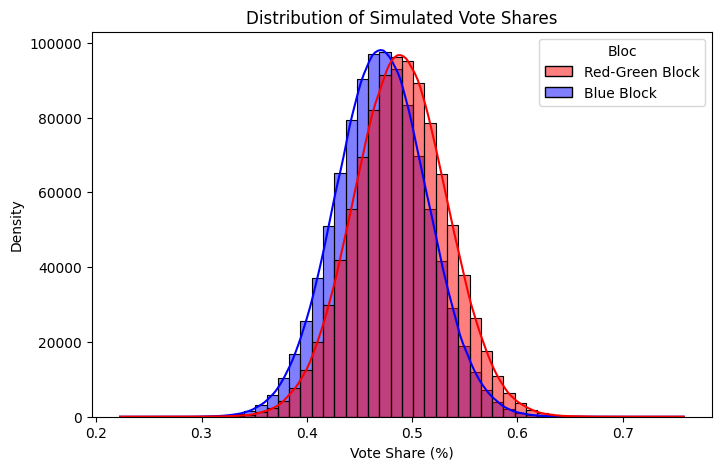

In [97]:

# Create a DataFrame with both red-green and blue votes
df_votes = pd.DataFrame({
    "Red-Green Block": red_green_votes,
    "Blue Block": blue_votes
})

# Melt the DataFrame for easier plotting
df_votes_melted = df_votes.melt(var_name="Bloc", value_name="Votes")

# Plot
plt.figure(figsize=(8, 5))
sns.histplot(data=df_votes_melted, x="Votes", hue="Bloc", kde=True, palette={"Red-Green Block": "red", "Blue Block": "blue"}, alpha=0.5, bins=50)
plt.xlabel("Vote Share (%)")
plt.ylabel("Density")
plt.title("Distribution of Simulated Vote Shares")
plt.show()


In [98]:
# Define party groupings
red_green_parties = ["Ap", "SV", "Sp", "Rodt", "MDG"]
blue_parties = ["Hoyre", "Frp", "KrF", "Venstre"]

# Calculate sum columns for each bloc
forecast_original_scale["Red-Green Block"] = forecast_original_scale[red_green_parties].sum(axis=1)
forecast_lower_original_scale["Red-Green Block"] = forecast_lower_original_scale[red_green_parties].sum(axis=1)
forecast_upper_original_scale["Red-Green Block"] = forecast_upper_original_scale[red_green_parties].sum(axis=1)

forecast_original_scale["Blue Block"] = forecast_original_scale[blue_parties].sum(axis=1)
forecast_lower_original_scale["Blue Block"] = forecast_lower_original_scale[blue_parties].sum(axis=1)
forecast_upper_original_scale["Blue Block"] = forecast_upper_original_scale[blue_parties].sum(axis=1)


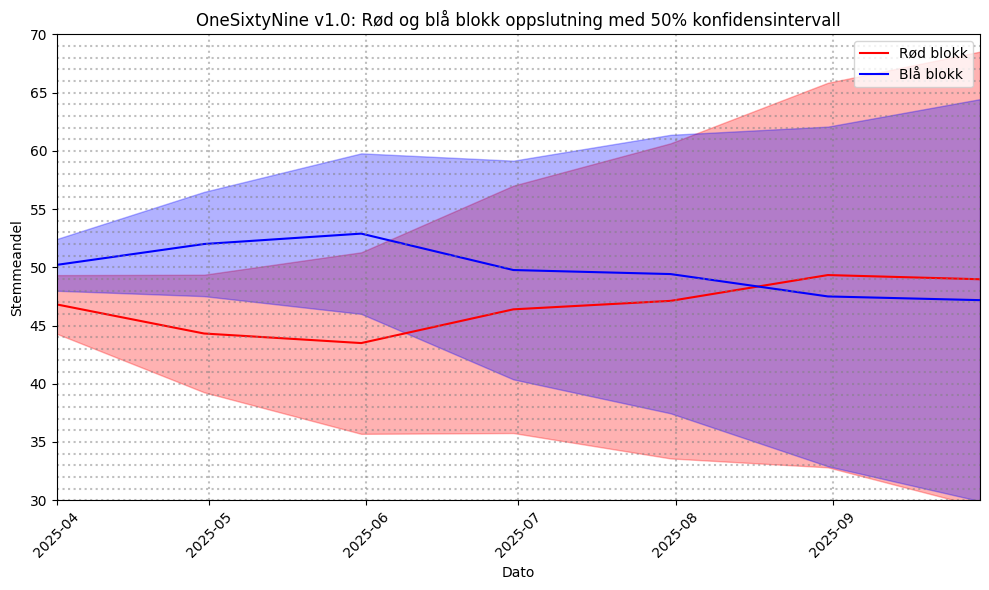

In [99]:
# Plot the red-green and blue block time series with confidence intervals
plt.figure(figsize=(10, 6))

# Plot Red-Green Block with confidence intervals
sns.lineplot(data=forecast_original_scale, x=forecast_original_scale.index, y="Red-Green Block", label="Rød blokk", color="red")
plt.fill_between(forecast_original_scale.index, 
                 forecast_lower_original_scale["Red-Green Block"], 
                 forecast_upper_original_scale["Red-Green Block"], 
                 color="red", alpha=0.3)

# Plot Blue Block with confidence intervals
sns.lineplot(data=forecast_original_scale, x=forecast_original_scale.index, y="Blue Block", label="Blå blokk", color="blue")
plt.fill_between(forecast_original_scale.index, 
                 forecast_lower_original_scale["Blue Block"], 
                 forecast_upper_original_scale["Blue Block"], 
                 color="blue", alpha=0.3)

dates = pd.date_range(start="2025-04-01", end="2025-09-30", freq="MS")  # "MS" = Month Start
for date in dates:
    plt.axvline(date, color="gray", linestyle="dotted", alpha=0.5)

# Add horizontal grid lines every 5%
for percent in range(30, 70, 1):
    plt.axhline(percent, color="gray", linestyle="dotted", alpha=0.5)

# Customize the plot
plt.xlim(np.datetime64("2025-04-01"), np.datetime64("2025-09-30"))  # Manually set max date to Sept 2025
plt.ylim(30,70)  # Manually set max date to Sept 2025
plt.title('OneSixtyNine v1.0: Rød og blå blokk oppslutning med 50% konfidensintervall')
plt.xlabel('Dato')
plt.ylabel('Stemmeandel')
plt.legend()
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.tight_layout()

# Show the plot
plt.show()
